# Effect of Corona in INDIA



In [27]:
!pip install pycountry
!pip install plotly.express
!pip install folium

  Using cached https://files.pythonhosted.org/packages/d4/d6/8a2906f51e073a4be80cab35cfa10e7a34853e60f3ed5304ac470852a08d/plotly_express-0.4.1-py2.py3-none-any.whl
     |████████████████████████████████| 92kB 6.2MB/s eta 0:00:011


In [28]:
# import the necessary libraries
import numpy as np 
import pandas as pd 
import os

# Visualisation libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import pycountry

from plotly.offline import init_notebook_mode, iplot 
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot


!pip install pywaffle
from pywaffle import Waffle


py.init_notebook_mode(connected=True)
import folium 
from folium import plugins
plt.style.use("fivethirtyeight")# for pretty graphs

# Increase the default plot size and set the color scheme
plt.rcParams['figure.figsize'] = 8, 5
#plt.rcParams['image.cmap'] = 'viridis'

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# Disable warnings 
import warnings
warnings.filterwarnings('ignore')


# Part 1: Analysing the condition in India

The first **COVID-19** case was reported on on 30 January in a student who arrived in **Kerala** state from Wuhan.Then 2 more cases were reported in the enxt 2 days in Kerala again. For almost a month, no new cases was reported in India, however, on 8th March, five new cases of corona virus in Kerala were again reported and since then the cases have been rising affecting **14** states, till now.Here is a brief timeline of the cases in India


In [30]:
# Reading the datasets

df= pd.read_excel('../input/coronavirus-cases-in-india/Covid cases in India.xlsx')
df_india = df.copy()

# Coordinates of India States and Uts
India_coord = pd.read_excel('../input/coronavirus-cases-in-india/Indian Coordinates.xlsx')

#Day by day data of India, Korea and Italy
dbd_India = pd.read_excel('../input/coronavirus-cases-in-india/per_day_cases.xlsx',sheet_name='India')
dbd_Italy = pd.read_excel('../input/coronavirus-cases-in-india/per_day_cases.xlsx',sheet_name="Italy")
dbd_Korea = pd.read_excel('../input/coronavirus-cases-in-india/per_day_cases.xlsx',sheet_name="Korea")



FileNotFoundError: [Errno 2] No such file or directory: '../input/coronavirus-cases-in-india/Covid cases in India.xlsx'

In [3]:
df.drop(['S. No.'],axis=1,inplace=True)
df['Total cases'] = df['Total Confirmed cases (Indian National)'] + df['Total Confirmed cases ( Foreign National )']
df['Active cases'] = df['Total cases'] - (df['Recovered'] + df['Deaths'])
print(f'Total number of Confirmed COVID 2019 cases across India:', df['Total cases'].sum())
print(f'Total number of Active COVID 2019 cases across India:', df['Active cases'].sum())

Total number of Confirmed COVID 2019 cases across India: 137
Total number of Active COVID 2019 cases across India: 120


## 1.1 Distribution of Cases in India

In [4]:

#https://www.kaggle.com/nxrprime/styling-data-frames-covid-19-vs-conferences
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: pink' if v else '' for v in is_max]



#df.style.apply(highlight_max,subset=['Total Confirmed cases (Indian National)', 'Total Confirmed cases ( Foreign National )'])
df.style.apply(highlight_max,subset=['Recovered', 'Deaths','Total cases','Active cases'])

,Name of State / UT,Total Confirmed cases (Indian National),Total Confirmed cases ( Foreign National ),Recovered,Deaths,Total cases,Active cases
0,Andhra Pradesh,1,0,0,0,1,1
1,Delhi,8,0,2,1,8,5
2,Haryana,1,14,0,0,15,15
3,Karnataka,11,0,0,1,11,10
4,Kerala,24,2,3,0,26,23
5,Maharashtra,36,3,0,1,39,38
6,Odisha,1,0,0,0,1,1
7,Punjab,1,0,0,0,1,1
8,Rajasthan,2,2,3,0,4,1
9,Tamil Nadu,1,0,0,0,1,1


## 1.2 State/Union Territories wise number of Covid-19 cases

In [5]:


x = df.groupby('Name of State / UT')['Active cases'].sum().sort_values(ascending=False).to_frame()
x.style.background_gradient(cmap='Reds')



,Active cases
Name of State / UT,
Maharashtra,38
Kerala,23
Haryana,15
Uttar Pradesh,10
Karnataka,10
Union Territory of Ladakh,6
Delhi,5
Telengana,4
Union Territory of Jammu and Kashmir,3


In [6]:
fig = px.bar(df.sort_values('Active cases', ascending=False).sort_values('Active cases', ascending=True), 
             x="Active cases", y="Name of State / UT", title='Total Active Cases', text='Active cases', orientation='h', 
             width=700, height=700, range_x = [0, max(df['Active cases'])])
fig.update_traces(marker_color='#46cdcf', opacity=0.8, textposition='outside')

fig.update_layout(plot_bgcolor='rgb(250, 242, 242)')
fig.show()

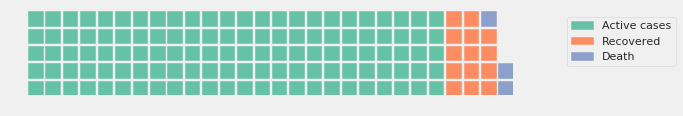

In [7]:
df_condensed = pd.DataFrame([df['Active cases'].sum(),df['Recovered'].sum(),df['Deaths'].sum()],columns=['Cases'])
df_condensed.index=['Active cases','Recovered','Death']
df_condensed


fig = plt.figure(
    FigureClass=Waffle, 
    rows=5,
    values=df_condensed['Cases'],
    labels=list(df_condensed.index),
    figsize=(10, 3),
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.1, 1)}
)

## 1.3 National vs Foreign cases

In [8]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("National Cases","Foreign Cases"))

temp = df.sort_values('Total Confirmed cases (Indian National)', ascending=False).sort_values('Total Confirmed cases (Indian National)', ascending=False)

fig.add_trace(go.Bar( y=temp['Total Confirmed cases (Indian National)'], x=temp["Name of State / UT"],  
                     marker=dict(color=temp['Total Confirmed cases (Indian National)'], coloraxis="coloraxis")),
              1, 1)
                     
temp1 = df.sort_values('Total Confirmed cases ( Foreign National )', ascending=False).sort_values('Total Confirmed cases ( Foreign National )', ascending=False)

fig.add_trace(go.Bar( y=temp1['Total Confirmed cases ( Foreign National )'], x=temp1["Name of State / UT"],  
                     marker=dict(color=temp1['Total Confirmed cases ( Foreign National )'], coloraxis="coloraxis")),
              1, 2)                     
                     

fig.update_layout(coloraxis=dict(colorscale='rdbu'), showlegend=False,title_text="National vs Foreign Cases",plot_bgcolor='rgb(250, 242, 242)')
fig.show()






## 1.4 Visualising the spread geographically

In [9]:
# create map and display it

df_full = pd.merge(India_coord,df,on='Name of State / UT')
map = folium.Map(location=[20, 80], zoom_start=3.5,tiles='Stamen Toner')

for lat, lon, value, name in zip(df_full['Latitude'], df_full['Longitude'], df_full['Active cases'], df_full['Name of State / UT']):
    folium.CircleMarker([lat, lon],
                        radius=value*0.7,
                        popup = ('<strong>State</strong>: ' + str(name).capitalize() + '<br>'
                                '<strong>Confirmed Cases</strong>: ' + str(value) + '<br>'),
                        color='red',
                        
                        fill_color='red',
                        fill_opacity=0.3 ).add_to(map)
map

## 1.5 Confirmed vs Recovered figures

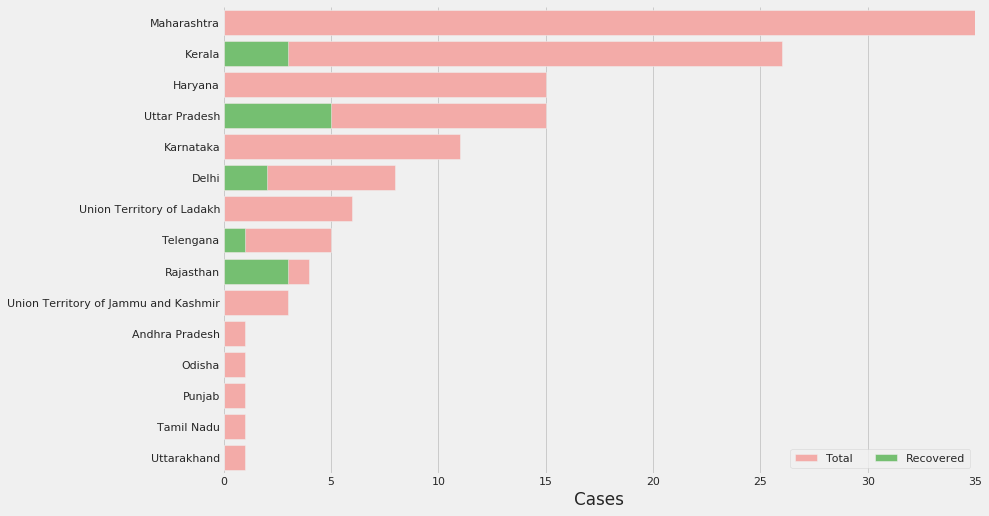

In [10]:


f, ax = plt.subplots(figsize=(12, 8))
data = df_full[['Name of State / UT','Total cases','Recovered','Deaths']]
data.sort_values('Total cases',ascending=False,inplace=True)
sns.set_color_codes("pastel")
sns.barplot(x="Total cases", y="Name of State / UT", data=data,
            label="Total", color="r")

sns.set_color_codes("muted")
sns.barplot(x="Recovered", y="Name of State / UT", data=data,
            label="Recovered", color="g")


# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 35), ylabel="",
       xlabel="Cases")
sns.despine(left=True, bottom=True)

## 1.6 How the Coronavirus cases are rising?

In [11]:
# Rise in COVID-19 cases in India
fig = go.Figure()
fig.add_trace(go.Scatter(x=dbd_India['Date'], y=dbd_India['Total Cases'],
                    mode='lines+markers',name='Total Cases'))
fig.update_layout(title_text='Trend of Coronavirus Cases in India(Cumulative cases)',plot_bgcolor='rgb(250, 242, 242)')

fig.show()


# New COVID-19 cases reported daily in India

import plotly.express as px
fig = px.bar(dbd_India, x="Date", y="New Cases", barmode='group',
             height=400)
fig.update_layout(title_text='New Coronavirus Cases in India per day',plot_bgcolor='rgb(250, 242, 242)')

fig.show()


# Part B: Is the trend similar to Italy and S.Korea?

India has already crossed 100 cases. It is very important to contain the situation in the coming week.The numbers of coronavirus patients starting doubling after these countries hit the 100 mark and almost starting increasing exponentially. Incase you want to understand what is exponential growth and how cases see an abrupt increase , here is a great video by [**3Blue1Brown**](https://www.youtube.com/watch?v=Kas0tIxDvrg):


In [12]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/Kas0tIxDvrg" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

## 2.1 Cumulative cases in India, Italy and S.Korea

In [13]:
fig = px.bar(dbd_Italy, x="Date", y="Total Cases", color='Total Cases', orientation='v', height=600,
             title='Confirmed Cases in India', color_discrete_sequence = px.colors.cyclical.mygbm)

fig.update_layout(plot_bgcolor='rgb(250, 242, 242)')
fig.show()

fig = px.bar(dbd_Korea, x="Date", y="Total Cases", color='Total Cases', orientation='v', height=600,
             title='Confirmed Cases in Korea', color_discrete_sequence = px.colors.cyclical.mygbm)

fig.update_layout(plot_bgcolor='rgb(250, 242, 242)')
fig.show()

fig = px.bar(dbd_India, x="Date", y="Total Cases", color='Total Cases', orientation='v', height=600,
             title='Confirmed Cases in India', color_discrete_sequence = px.colors.cyclical.mygbm)

fig.update_layout(plot_bgcolor='rgb(250, 242, 242)')
fig.show()

## 2.2 Comparison between the rise of cases in S.Korea, Italy and India

In [14]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=2,
    specs=[[{}, {}],
           [{"colspan": 2}, None]],
    subplot_titles=("S.Korea","Italy", "India"))

fig.add_trace(go.Bar(x=dbd_Korea['Date'], y=dbd_Korea['Total Cases'],
                    marker=dict(color=dbd_Korea['Total Cases'], coloraxis="coloraxis")),
              1, 1)

fig.add_trace(go.Bar(x=dbd_Italy['Date'], y=dbd_Italy['Total Cases'],
                    marker=dict(color=dbd_Italy['Total Cases'], coloraxis="coloraxis")),
              1, 2)

fig.add_trace(go.Bar(x=dbd_India['Date'], y=dbd_India['Total Cases'],
                    marker=dict(color=dbd_India['Total Cases'], coloraxis="coloraxis")),
              2, 1)

fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=False,title_text="Total Confirmed cases(Cumulative)")

fig.update_layout(plot_bgcolor='rgb(250, 242, 242)')
fig.show()

In [15]:

from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=2,
    specs=[[{}, {}],
           [{"colspan": 2}, None]],
    subplot_titles=("S.Korea","Italy", "India"))

fig.add_trace(go.Scatter(x=dbd_Korea['Date'], y=dbd_Korea['Total Cases'],
                    marker=dict(color=dbd_Korea['Total Cases'], coloraxis="coloraxis")),
              1, 1)

fig.add_trace(go.Scatter(x=dbd_Italy['Date'], y=dbd_Italy['Total Cases'],
                    marker=dict(color=dbd_Italy['Total Cases'], coloraxis="coloraxis")),
              1, 2)

fig.add_trace(go.Scatter(x=dbd_India['Date'], y=dbd_India['Total Cases'],
                    marker=dict(color=dbd_India['Total Cases'], coloraxis="coloraxis")),
              2, 1)

fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=False,title_text="Trend of Coronavirus cases")

fig.update_layout(plot_bgcolor='rgb(250, 242, 242)')
fig.show()

## 2.3 Trend after surpassing 100 cases

In [1]:
import plotly.graph_objects as go
import numpy as np

title = 'Main Source for News'
labels = ['S.Korea', 'Italy', 'India']
colors = ['rgb(0,128,0)', 'rgb(255,0,0)', 'rgb(49,130,189)']

mode_size = [8, 8, 12]
line_size = [2, 2, 6]

fig = go.Figure()


fig.add_trace(go.Scatter(x=dbd_Korea['Days after surpassing 100 cases'], 
                 y=dbd_Korea['Total Cases'],mode='lines',
                 name=labels[0],
                 line=dict(color=colors[0], width=line_size[0]),            
                 connectgaps=True,
    ))
fig.add_trace(go.Scatter(x=dbd_Italy['Days after surpassing 100 cases'], 
                 y=dbd_Italy['Total Cases'],mode='lines',
                 name=labels[1],
                 line=dict(color=colors[1], width=line_size[1]),            
                 connectgaps=True,
    ))

fig.add_trace(go.Scatter(x=dbd_India['Days after surpassing 100 cases'], 
                 y=dbd_India['Total Cases'],mode='lines',
                 name=labels[2],
                 line=dict(color=colors[2], width=line_size[2]),            
                 connectgaps=True,
    ))
    
    
    
annotations = []

annotations.append(dict(xref='paper', yref='paper', x=0.5, y=-0.1,
                              xanchor='center', yanchor='top',
                              text='Days after surpassing 100 cases ',
                              font=dict(family='Arial',
                                        size=12,
                                        color='rgb(150,150,150)'),
                              showarrow=False))

fig.update_layout(annotations=annotations,plot_bgcolor='white',yaxis_title='Cumulative cases')

fig.show()

ModuleNotFoundError: No module named 'plotly.graph_objects'